In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

save_best_model = ModelCheckpoint("wagi_best.h5py",save_best_only=True)
lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, save_best_model, early_stopping])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4200      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
943/943 [==============================] - ETA: 0s - loss: 0.4055 - accuracy: 0.8153WARNING:tensorflow:From C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow

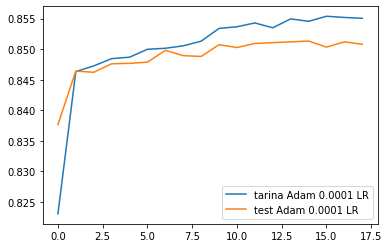

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam 0.0001 LR")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam 0.0001 LR")


plt.legend()
plt.show()

In [7]:
model.load_weights("wagi_best.h5py")
model.evaluate(X_test,y_test)

# Zad.
Do poniższych danych dobierz paametr
```python
patience=
```

Zwizualizuj wyniki dla obu modeli.

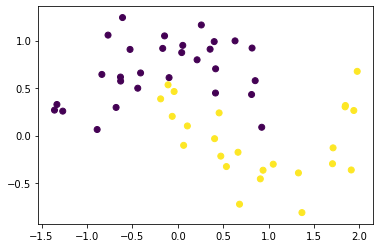

In [8]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [9]:
from tensorflow.keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_6 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.7015 - accuracy: 0.5849 - val_loss: 0.9707 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.8210 - accuracy: 0.5472 - val_

Epoch 110/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0700 - accuracy: 0.9811 - val_loss: 0.2521 - val_accuracy: 0.8936
Epoch 111/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0703 - accuracy: 0.9811 - val_loss: 0.2541 - val_accuracy: 0.8936
Epoch 112/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0670 - accuracy: 0.9811 - val_loss: 0.2355 - val_accuracy: 0.8936
Epoch 113/1000
2/2 [==============================] - 0s 11ms/step - loss: 0.0677 - accuracy: 0.9811 - val_loss: 0.2244 - val_accuracy: 0.8936
Epoch 114/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0643 - accuracy: 0.9811 - val_loss: 0.2283 - val_accuracy: 0.8936
Epoch 115/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0607 - accuracy: 0.9811 - val_loss: 0.2320 - val_accuracy: 0.9149
Epoch 116/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0594 - accuracy: 0.9811 - val_loss: 0.2273 - val_accuracy: 0.9149

2/2 [==============================] - 0s 14ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1828 - val_accuracy: 0.9149
Epoch 225/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1853 - val_accuracy: 0.9149
Epoch 226/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.1862 - val_accuracy: 0.9149
Epoch 227/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1872 - val_accuracy: 0.9149
Epoch 228/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.1869 - val_accuracy: 0.9149
Epoch 229/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1860 - val_accuracy: 0.9149
Epoch 230/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1859 - val_accuracy: 0.9149
Epoch 231/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2018 - val_accuracy: 0.9149
Epoch 339/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2012 - val_accuracy: 0.9149
Epoch 340/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2012 - val_accuracy: 0.9149
Epoch 341/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2025 - val_accuracy: 0.9149
Epoch 342/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2032 - val_accuracy: 0.9149
Epoch 343/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2051 - val_accuracy: 0.9149
Epoch 344/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2057 - val_accuracy: 0.9149
Epoch 345/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2273 - val_accuracy: 0.9149
Epoch 396/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2257 - val_accuracy: 0.9149
Epoch 397/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2244 - val_accuracy: 0.9149
Epoch 398/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2226 - val_accuracy: 0.9149
Epoch 399/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2225 - val_accuracy: 0.9149
Epoch 400/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2223 - val_accuracy: 0.9149
Epoch 401/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2229 - val_accuracy: 0.9149
Epoch 402/1000

2/2 [==============================] - 0s 13ms/step - loss: 9.0116e-04 - accuracy: 1.0000 - val_loss: 0.2581 - val_accuracy: 0.9149
Epoch 510/1000
2/2 [==============================] - 0s 13ms/step - loss: 8.9832e-04 - accuracy: 1.0000 - val_loss: 0.2582 - val_accuracy: 0.9149
Epoch 511/1000
2/2 [==============================] - 0s 14ms/step - loss: 8.9510e-04 - accuracy: 1.0000 - val_loss: 0.2585 - val_accuracy: 0.9149
Epoch 512/1000
2/2 [==============================] - 0s 15ms/step - loss: 9.1962e-04 - accuracy: 1.0000 - val_loss: 0.2586 - val_accuracy: 0.9149
Epoch 513/1000
2/2 [==============================] - 0s 16ms/step - loss: 8.8395e-04 - accuracy: 1.0000 - val_loss: 0.2599 - val_accuracy: 0.9149
Epoch 514/1000
2/2 [==============================] - 0s 17ms/step - loss: 9.1683e-04 - accuracy: 1.0000 - val_loss: 0.2611 - val_accuracy: 0.9149
Epoch 515/1000
2/2 [==============================] - 0s 16ms/step - loss: 8.7717e-04 - accuracy: 1.0000 - val_loss: 0.2609 - val_acc

Epoch 565/1000
2/2 [==============================] - 0s 15ms/step - loss: 7.1209e-04 - accuracy: 1.0000 - val_loss: 0.2787 - val_accuracy: 0.9149
Epoch 566/1000
2/2 [==============================] - 0s 14ms/step - loss: 6.7974e-04 - accuracy: 1.0000 - val_loss: 0.2778 - val_accuracy: 0.9149
Epoch 567/1000
2/2 [==============================] - 0s 13ms/step - loss: 7.1510e-04 - accuracy: 1.0000 - val_loss: 0.2769 - val_accuracy: 0.9149
Epoch 568/1000
2/2 [==============================] - 0s 13ms/step - loss: 6.8312e-04 - accuracy: 1.0000 - val_loss: 0.2772 - val_accuracy: 0.9149
Epoch 569/1000
2/2 [==============================] - 0s 13ms/step - loss: 7.0055e-04 - accuracy: 1.0000 - val_loss: 0.2782 - val_accuracy: 0.9149
Epoch 570/1000
2/2 [==============================] - 0s 13ms/step - loss: 6.6464e-04 - accuracy: 1.0000 - val_loss: 0.2787 - val_accuracy: 0.9149
Epoch 571/1000
2/2 [==============================] - 0s 13ms/step - loss: 6.7246e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 676/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.2555e-04 - accuracy: 1.0000 - val_loss: 0.3125 - val_accuracy: 0.8936
Epoch 677/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.2549e-04 - accuracy: 1.0000 - val_loss: 0.3123 - val_accuracy: 0.8936
Epoch 678/1000
2/2 [==============================] - 0s 13ms/step - loss: 4.2667e-04 - accuracy: 1.0000 - val_loss: 0.3121 - val_accuracy: 0.8936
Epoch 679/1000
2/2 [==============================] - 0s 15ms/step - loss: 4.3057e-04 - accuracy: 1.0000 - val_loss: 0.3123 - val_accuracy: 0.8936
Epoch 680/1000
2/2 [==============================] - 0s 12ms/step - loss: 4.3780e-04 - accuracy: 1.0000 - val_loss: 0.3129 - val_accuracy: 0.8936
Epoch 681/1000
2/2 [==============================] - 0s 12ms/step - loss: 4.3020e-04 - accuracy: 1.0000 - val_loss: 0.3134 - val_accuracy: 0.8936
Epoch 682/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.2522e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 732/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.5416e-04 - accuracy: 1.0000 - val_loss: 0.3293 - val_accuracy: 0.8936
Epoch 733/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.4837e-04 - accuracy: 1.0000 - val_loss: 0.3297 - val_accuracy: 0.8936
Epoch 734/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.4227e-04 - accuracy: 1.0000 - val_loss: 0.3304 - val_accuracy: 0.8936
Epoch 735/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.4051e-04 - accuracy: 1.0000 - val_loss: 0.3310 - val_accuracy: 0.8936
Epoch 736/1000
2/2 [==============================] - 0s 17ms/step - loss: 3.4234e-04 - accuracy: 1.0000 - val_loss: 0.3315 - val_accuracy: 0.8936
Epoch 737/1000
2/2 [==============================] - 0s 12ms/step - loss: 3.4167e-04 - accuracy: 1.0000 - val_loss: 0.3322 - val_accuracy: 0.8936
Epoch 738/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.4241e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 788/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.8919e-04 - accuracy: 1.0000 - val_loss: 0.3447 - val_accuracy: 0.8936
Epoch 789/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.8651e-04 - accuracy: 1.0000 - val_loss: 0.3447 - val_accuracy: 0.8936
Epoch 790/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.8441e-04 - accuracy: 1.0000 - val_loss: 0.3447 - val_accuracy: 0.8723
Epoch 791/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.9196e-04 - accuracy: 1.0000 - val_loss: 0.3442 - val_accuracy: 0.8723
Epoch 792/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.8020e-04 - accuracy: 1.0000 - val_loss: 0.3442 - val_accuracy: 0.8723
Epoch 793/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.7982e-04 - accuracy: 1.0000 - val_loss: 0.3445 - val_accuracy: 0.8723
Epoch 794/1000
2/2 [==============================] - 0s 11ms/step - loss: 2.7896e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 844/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.3730e-04 - accuracy: 1.0000 - val_loss: 0.3550 - val_accuracy: 0.8723
Epoch 845/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.4246e-04 - accuracy: 1.0000 - val_loss: 0.3551 - val_accuracy: 0.8723
Epoch 846/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.3904e-04 - accuracy: 1.0000 - val_loss: 0.3553 - val_accuracy: 0.8723
Epoch 847/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.4229e-04 - accuracy: 1.0000 - val_loss: 0.3560 - val_accuracy: 0.8723
Epoch 848/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.3707e-04 - accuracy: 1.0000 - val_loss: 0.3562 - val_accuracy: 0.8723
Epoch 849/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.3995e-04 - accuracy: 1.0000 - val_loss: 0.3566 - val_accuracy: 0.8723
Epoch 850/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.3754e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 900/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.0088e-04 - accuracy: 1.0000 - val_loss: 0.3651 - val_accuracy: 0.8723
Epoch 901/1000
2/2 [==============================] - 0s 11ms/step - loss: 2.0054e-04 - accuracy: 1.0000 - val_loss: 0.3652 - val_accuracy: 0.8723
Epoch 902/1000
2/2 [==============================] - 0s 11ms/step - loss: 1.9993e-04 - accuracy: 1.0000 - val_loss: 0.3654 - val_accuracy: 0.8723
Epoch 903/1000
2/2 [==============================] - 0s 11ms/step - loss: 1.9939e-04 - accuracy: 1.0000 - val_loss: 0.3657 - val_accuracy: 0.8723
Epoch 904/1000
2/2 [==============================] - 0s 11ms/step - loss: 1.9863e-04 - accuracy: 1.0000 - val_loss: 0.3657 - val_accuracy: 0.8723
Epoch 905/1000
2/2 [==============================] - 0s 12ms/step - loss: 1.9809e-04 - accuracy: 1.0000 - val_loss: 0.3659 - val_accuracy: 0.8723
Epoch 906/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.0019e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 956/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.7452e-04 - accuracy: 1.0000 - val_loss: 0.3744 - val_accuracy: 0.8936
Epoch 957/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.7553e-04 - accuracy: 1.0000 - val_loss: 0.3744 - val_accuracy: 0.8936
Epoch 958/1000
2/2 [==============================] - 0s 12ms/step - loss: 1.7252e-04 - accuracy: 1.0000 - val_loss: 0.3741 - val_accuracy: 0.8936
Epoch 959/1000
2/2 [==============================] - 0s 12ms/step - loss: 1.7187e-04 - accuracy: 1.0000 - val_loss: 0.3735 - val_accuracy: 0.8723
Epoch 960/1000
2/2 [==============================] - 0s 12ms/step - loss: 1.7798e-04 - accuracy: 1.0000 - val_loss: 0.3731 - val_accuracy: 0.8723
Epoch 961/1000
2/2 [==============================] - 0s 11ms/step - loss: 1.7289e-04 - accuracy: 1.0000 - val_loss: 0.3731 - val_accuracy: 0.8723
Epoch 962/1000
2/2 [==============================] - 0s 11ms/step - loss: 1.7440e-04 - accuracy: 1.0000 - val_loss: 0

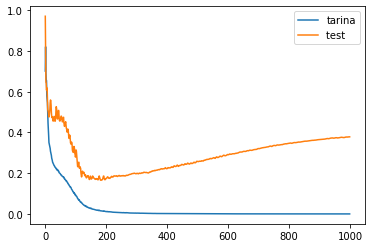

In [10]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


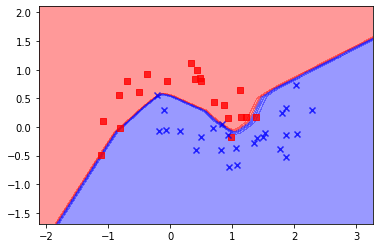

In [11]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

In [12]:
from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam_1 = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_1, early_stopping])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_9 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_10 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 0s 118ms/step - loss: 0.8183 - accuracy: 0.3396 - val_loss: 0.6748 - val_accuracy: 0.5532
Epoch 2/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.6941 - accuracy: 0.3962 - val

Epoch 110/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0630 - accuracy: 1.0000 - val_loss: 0.2032 - val_accuracy: 0.8936
Epoch 111/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0633 - accuracy: 1.0000 - val_loss: 0.2034 - val_accuracy: 0.9149
Epoch 112/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0605 - accuracy: 1.0000 - val_loss: 0.2048 - val_accuracy: 0.9149
Epoch 113/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0557 - accuracy: 1.0000 - val_loss: 0.2160 - val_accuracy: 0.9149
Epoch 114/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0553 - accuracy: 0.9811 - val_loss: 0.2201 - val_accuracy: 0.9149
Epoch 115/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0548 - accuracy: 0.9623 - val_loss: 0.2143 - val_accuracy: 0.9149
Epoch 116/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0523 - accuracy: 0.9811 - val_loss: 0.1993 - val_accuracy: 0.9149

Epoch 167/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.1786 - val_accuracy: 0.8936
Epoch 168/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.1889 - val_accuracy: 0.9149
Epoch 169/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0168 - accuracy: 1.0000 - val_loss: 0.1958 - val_accuracy: 0.9362
Epoch 170/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 0.1981 - val_accuracy: 0.9362
Epoch 171/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.1967 - val_accuracy: 0.9362
Epoch 172/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.1928 - val_accuracy: 0.9149
Epoch 173/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.1893 - val_accuracy: 0.8936

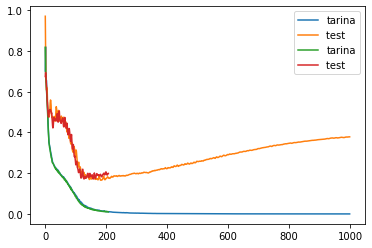

In [13]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

plt.plot(history_Adam_1.history['loss'], label = "tarina")
plt.plot(history_Adam_1.history['val_loss'], label = "test ")

plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


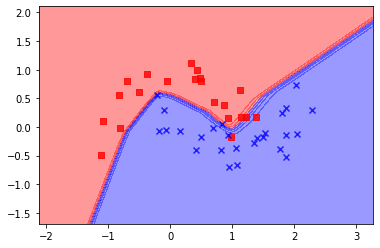

In [14]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()